In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


# Data viz

In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

In [4]:
print(df_medical['sex'].unique(),  df_medical['smoker'].unique(), df_medical['region'].unique(), df_medical['children'].unique())
print(df_medical.describe())

['female' 'male'] ['yes' 'no'] ['southwest' 'southeast' 'northwest' 'northeast'] [0 1 3 2 5 4]
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [4]:
df_medical[df_medical['sex'] == 'male']['charges'].mean(), df_medical[df_medical['sex'] == 'female']['charges'].mean()

(13956.751177721893, 12569.578843835347)

In [5]:
df_medical[df_medical['smoker'] == 'yes']['charges'].mean(), df_medical[df_medical['smoker'] == 'no']['charges'].mean()

(32050.23183153284, 8434.268297856204)

In [13]:
df_medical['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [10]:
df_medical[df_medical['bmi'] > 30]['charges'].mean(), df_medical[df_medical['bmi'] < 25]['charges'].mean()

(15560.92632126241, 10282.224474367347)

In [12]:
df_medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data scaling

In [3]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

from sklearn.linear_model import LinearRegression, Ridge
ridge = Ridge()
ridge.fit(X_dat, y_dat)
print("ridge score", ridge.score(X_dat, y_dat))

lr = LinearRegression()
lr.fit(X_dat, y_dat)
print("lr score", lr.score(X_dat, y_dat))

ridge score 0.7508822838629774
lr score 0.7433258088081168


In [90]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth= 2)
dtr.fit(X_dat, y_dat)
dtr.score(X_dat, y_dat)

0.827363054973973

In [45]:
filter_group = ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']

In [46]:
# tranining on data for only each group
from sklearn.model_selection import train_test_split
random_seed = 21
X_train, X_test, y_train, y_test = train_test_split(X_dat, 
                                                    y_dat, test_size = 0.2,
                                                    shuffle=True, random_state= random_seed)

models_lr_dict = {}
group_sizes = {}

for g in filter_group:
    indices = (X_train[g] == 1)
    model_lr = LinearRegression()
    model_lr.fit(X_train[indices], y_train[indices])
    key = g
    group_sizes[key] = indices.sum() #sum of all the trues
    models_lr_dict[key] = model_lr

In [47]:
for g in filter_group:
    indices = (X_test[g] == 1)
    key = g
    r2_score_lr = models_lr_dict[key].score(X_test[indices], y_test[indices])
    print(f" {key}, test group size {group_sizes[key]}  r2 score for least squares is {r2_score_lr:.4f}")

 sex_male, test group size 545  r2 score for least squares is 0.7740
 sex_female, test group size 525  r2 score for least squares is 0.6788
 smoker_no, test group size 855  r2 score for least squares is 0.3335
 smoker_yes, test group size 215  r2 score for least squares is 0.7120


In [49]:
def cross_test_models(model_dict: dict):
    '''
        model_dict: maps keys to linear model, these linear models are already trained and have weights
        sex_cats: labels for the different sexes
        race_cats: labels for the different races
        This function computes the performance of one model on another models data

        With an example, model_dict['SEX_1'] has the linear model trained only of those points which have SEX == 1
        we will test its performance on all the other groups data.
    '''
    keys = list(model_dict.keys())
    l = len(keys)
    mat_2d = np.zeros((l, l))
    for i in range(l):
        model_i = model_dict[keys[i]]
        for j in range(l):
            key = keys[j]
            indices_j = (X_test[key] == 1)
            mat_2d[i, j] = model_i.score(X_test[indices_j], y_test[indices_j]) # how model i performs on test data meant for model j, R2 score
    return mat_2d, keys

In [50]:
import numpy as np
crossmat, keys = cross_test_models(models_lr_dict)
print(crossmat, keys)

[[  0.77395713   0.67423761   0.2718629    0.34950263]
 [  0.77813946   0.67880169   0.25524712   0.39194409]
 [ -0.20102872  -0.14835755   0.33352264  -4.64742037]
 [ -2.0494803   -3.80947698 -17.23561065   0.71200909]] ['sex_male', 'sex_female', 'smoker_no', 'smoker_yes']


<Axes: >

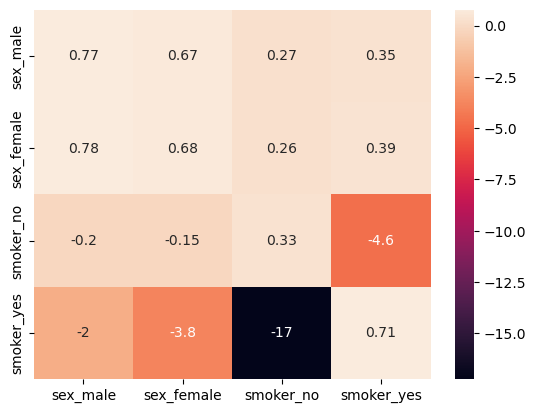

In [51]:
import seaborn as sns # for data visualization
sns.heatmap(crossmat, annot=True, xticklabels=keys, yticklabels=keys)

In [63]:
A_t_ss = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female', 
                    df_medical['smoker'] == 'yes', df_medical['smoker']=='no'],
                    axis = 1).to_numpy()

A_t_ss = np.hstack((A_t_ss, np.ones((A_t_ss.shape[0],1)))) # adding the always on

In [65]:
np.all(A_t_ss.sum(axis = 1) == 3), np.sum(A_t_ss, axis = 0)

(True, array([ 676.,  662.,  274., 1064., 1338.]))

In [66]:
X_dat.head(), y_dat.head()

(        age       bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0  0.021739  0.321227       0.0         1.0       0.0        0.0         1.0   
 1  0.000000  0.479150       0.2         0.0       1.0        1.0         0.0   
 2  0.217391  0.458434       0.6         0.0       1.0        1.0         0.0   
 3  0.326087  0.181464       0.0         0.0       1.0        1.0         0.0   
 4  0.304348  0.347592       0.0         0.0       1.0        1.0         0.0   
 
    region_northeast  region_northwest  region_southeast  region_southwest  
 0               0.0               0.0               0.0               1.0  
 1               0.0               0.0               1.0               0.0  
 2               0.0               0.0               1.0               0.0  
 3               0.0               1.0               0.0               0.0  
 4               0.0               1.0               0.0               0.0  ,
 0    0.251611
 1    0.009636
 2    0.053115
 3  

In [ ]:
# Sex group
# X_dat = df_medical_mm_oh.drop('charges', axis=1)
# y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
# filename = 'ls_medical_ss'
filename = 'ridge_medical_ss'

# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0)
expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_ss, expridge)

dirname = './models_adult/Anh/'

# experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0) for _ in range(A_t_ss.shape[1])]
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_ss.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_ss, experts)

In [68]:
# with ls experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 9.340432693981805 9.056613923934176 True
1 7.870279204337945 7.775014640401702 True
2 9.819313779250635 9.599300260487292 True
3 7.391398119069116 7.232328303848592 True
4 17.210711898319786 16.831628564335887 True
5


In [70]:
# with ridge experts
cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
cumloss_base = b_ridgebase.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 17.882773372793633 10.663511133777103 True
1 13.526108453162125 9.31153111995223 True
2 20.204301634660876 10.864175680568108 True
3 11.204580191294857 9.110866573161221 True
4 31.40888182595572 19.97504225372932 True
5


In [78]:
dirname = './models_adult/baseline/'
# filename = 'ls_medical_ss'
# filename = 'ridge_medical_ss'
filename = 'htree_medical_ss'


# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0)
X_dat_dict = X_dat.to_dict(orient='records')
expridge = OnlineHoeffdingTree(X_dat_dict, y_dat)
b_tree = build_baseline_alwayson(dirname, filename, A_t_ss, expridge)

dirname = './models_adult/Anh/'

# experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0.0) for _ in range(A_t_ss.shape[1])]
experts = [OnlineHoeffdingTree(X_dat_dict, y_dat) for _ in range(A_t_ss.shape[1])]
b_Anh_tree = build_Anh(dirname, filename, A_t_ss, experts)

100%|██████████| 1338/1338 [00:00<00:00, 1489.04it/s]


In [79]:
# with ridge experts
cumloss_groupwise_ada = b_Anh_tree.Anh.cumloss_groupwise_ada
cumloss_base = b_tree.expert.cumloss_groupwise
count_ada_better = 0
for g_ind in range(A_t_ss.shape[1]):
    base = cumloss_base[g_ind][-1]
    ada = cumloss_groupwise_ada[g_ind][-1]
    if base >= ada:
        count_ada_better += 1
    print(g_ind, base, ada , base >= ada)
print(count_ada_better)

0 9.343638190986532 7.736458565350479 True
1 7.806205459038698 7.180528557457914 True
2 9.598916699896055 7.906813881133385 True
3 7.550926950129177 7.010173241675015 True
4 17.149843650025264 14.916987122808399 True
5


# Groups 
- Age: young, middle , old aged
- Bmi: under, healthy, over, obese weight
- Smoker: yes, no
- Sex: male, female

In [16]:
df_medical['age'].describe(), df_medical['bmi'].describe()

(count    1338.000000
 mean       39.207025
 std        14.049960
 min        18.000000
 25%        27.000000
 50%        39.000000
 75%        51.000000
 max        64.000000
 Name: age, dtype: float64,
 count    1338.000000
 mean       30.663397
 std         6.098187
 min        15.960000
 25%        26.296250
 50%        30.400000
 75%        34.693750
 max        53.130000
 Name: bmi, dtype: float64)

<Axes: >

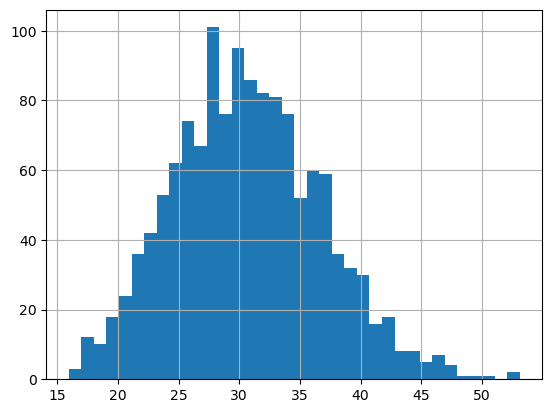

In [17]:
df_medical['bmi'].hist(bins=50-15+1)

In [4]:
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight 
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

# A_t_age, A_t_bmi, A_t_smoker, A_t_sex

In [5]:
A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
A_t_medical_groups.sum(axis=0)

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64

In [6]:
# code for plotting the regret curves
from sklearn.linear_model import LinearRegression, Ridge
from scipy.linalg import lstsq

def plot_Anh_minus_besthindsight(cl_ada_g: np.array, cl_metaexp_g: np.array, X_dat_g, y_dat_g, num_points = 10):
    '''
        cl_ada_g: array of shape (Tg,) having the cumulative loss of Anh on this group subsequence
        cl_metaexp_g: array of shape (Tg,) having the cumulative loss of this group meta expert
        X_dat_g: rows of the original dataframe where only group g is active
    '''
    Tg, d = X_dat_g.shape
    sse = [] # sum of squared errors for the best in hindsight, saved in this
    thetasq = [] # thetanorm squared
    pos = np.linspace(Tg // num_points, Tg-1, dtype = int, num = num_points) # positions in the dataframe to find best in hindsight 
    for p in pos:
        X_batch = X_dat_g[:p]
        y_batch = y_dat_g[:p]
        
        # Using sklearn
        lr = LinearRegression()
        lr.fit(X_batch, y_batch)
        sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))

        # Using scipy
        # X_batch_np = X_batch.to_numpy()
        # y_batch_np = y_batch.to_numpy()
        # theta_ls, _, _, _ = lstsq(X_batch_np, y_batch_np)
        # y_pred_ls = X_batch_np @ theta_ls
        # sse.append(np.sum((y_pred_ls - y_batch_np)**2))
        # thetasq.append(np.linalg.norm(lr.coef_)**2)

    sse = np.array(sse)
    plt.plot(pos, cl_ada_g[pos] - sse, label = 'ada - besthind_ls')
    plt.fill_between(pos, cl_ada_g[pos] - sse - 1, cl_ada_g[pos] - sse + 1, alpha = 0.5)
    # plt.plot(pos,pos**0.5 +  d * np.log(1 + pos), label = 'sqrt T +  dlog(T+1)')
    plt.legend()
    plt.show()


In [15]:
A_t_med_shuf = A_t_medical_groups.to_numpy()
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
filename = 'ridge_medical_regretinvestigation'

expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
dirname = './models_adult/Anh/'
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)

100%|██████████| 1338/1338 [00:02<00:00, 519.98it/s]


young 574


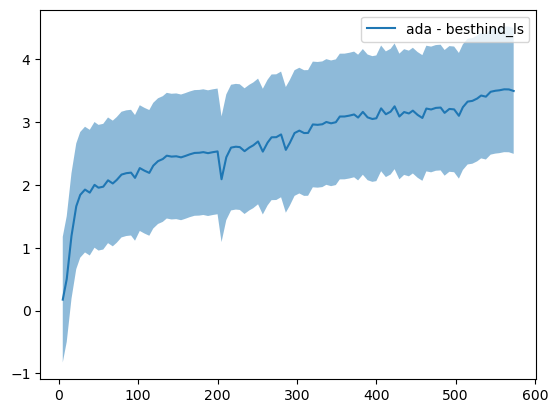

middle 408


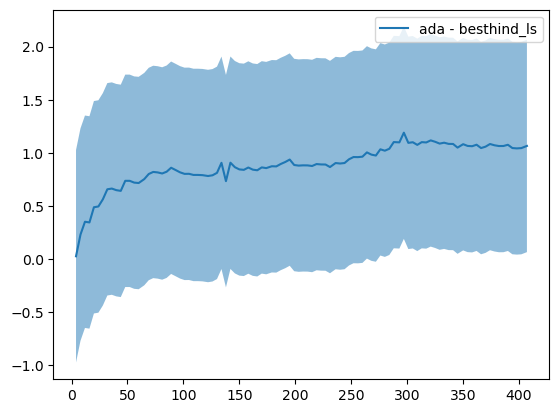

old 356


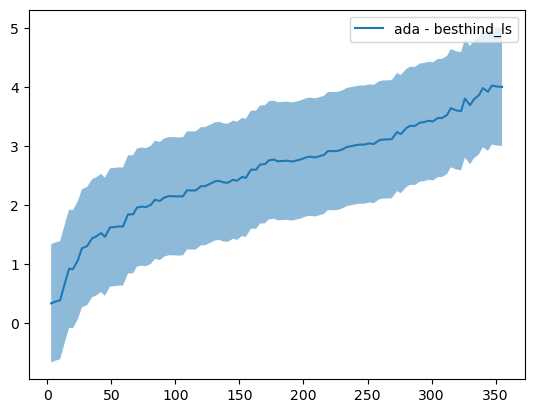

underweight 20


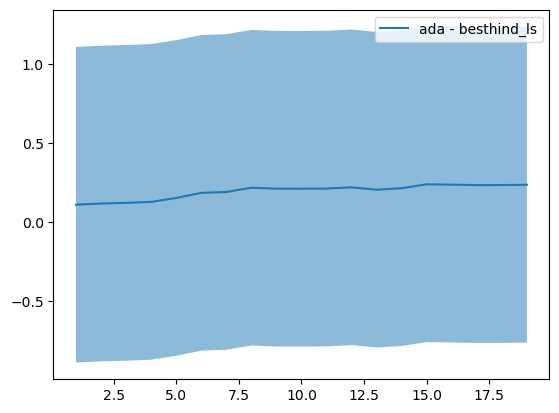

healthyweight 225


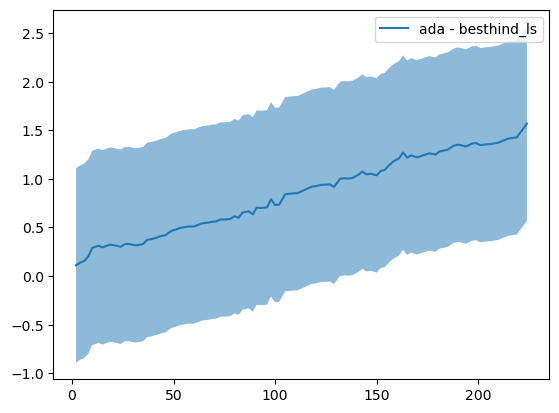

overweight 386


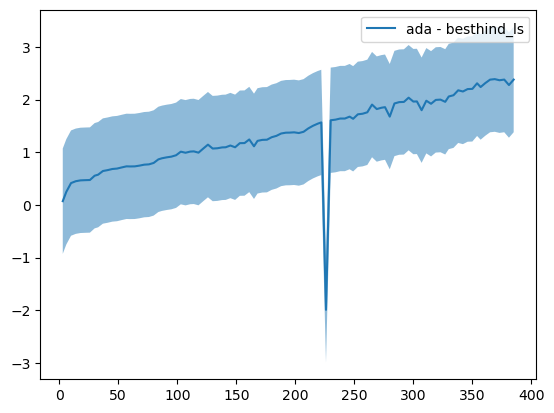

obese 707


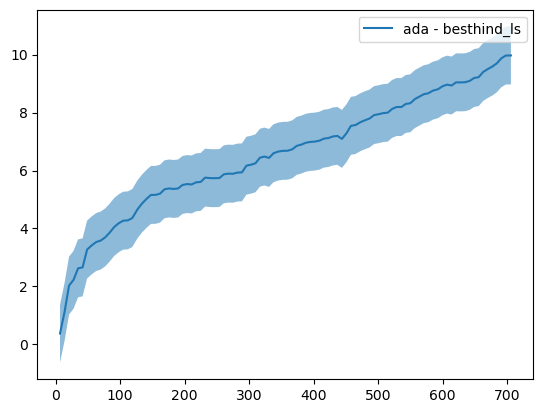

smoker 274


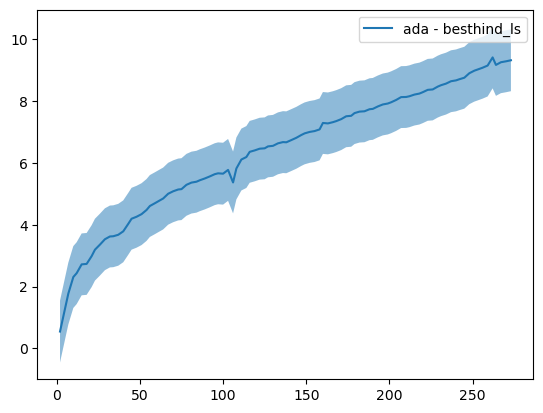

non-smoker 1064


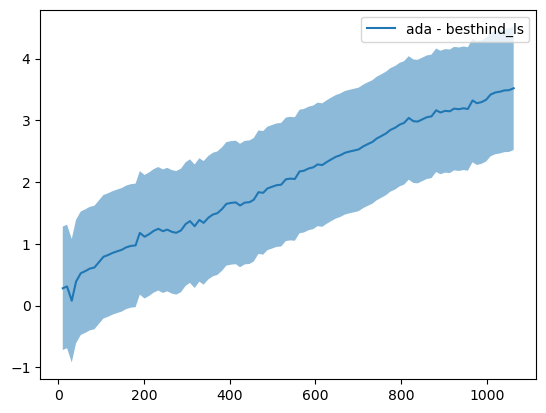

male 676


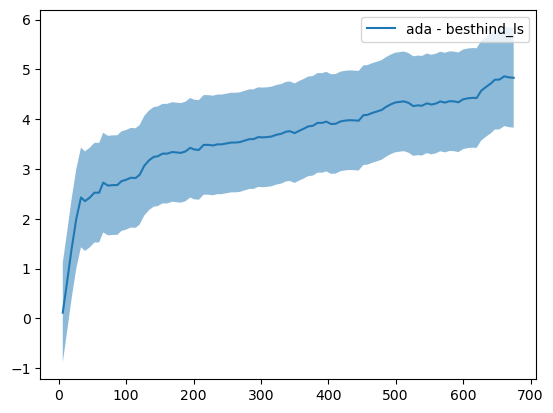

female 662


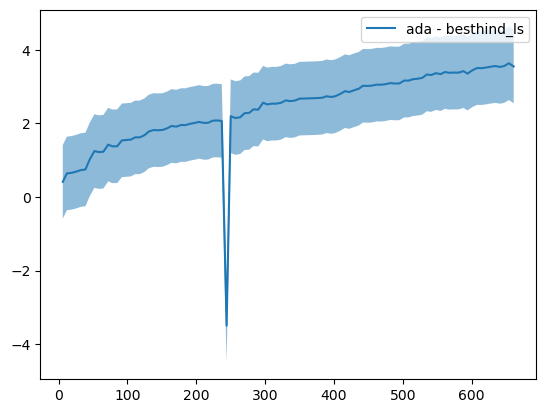

always_on 1338


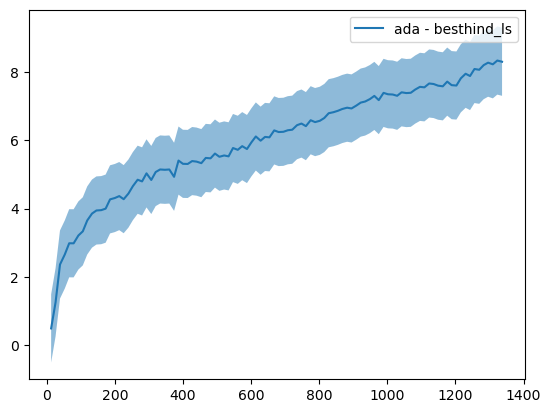

In [8]:
# cl_group_metaexp = Anhrm.cumloss_groupwise_metaexp TODO
Anh = b_Anh.Anh
for g_ind, gname in enumerate(A_t_medical_groups.columns):
    indices_g = (A_t_medical_groups[gname] == 1)
    X_dat_g = df_medical_mm_oh[indices_g].drop('charges', axis=1)
    y_dat_g = df_medical_mm_oh[indices_g]['charges']
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

In [17]:
from bilevel.manual_inv_LinearExpert import *

A_t_med_shuf = A_t_medical_groups.to_numpy()
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

X_dat_np = X_dat.to_numpy()
y_dat_np = y_dat.to_numpy()

dirname = './models_adult/baseline/'
filename = 'ridge_medical_regretinvestigation'

expridge = Manual_inv_LinearExpert(X_dat_np, y_dat_np, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
dirname = './models_adult/Anh/'
experts = [Manual_inv_LinearExpert(X_dat_np, y_dat_np, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)

100%|██████████| 1338/1338 [00:00<00:00, 5512.84it/s]


young 574


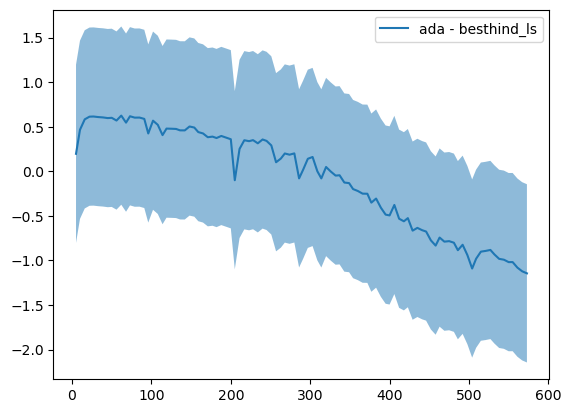

middle 408


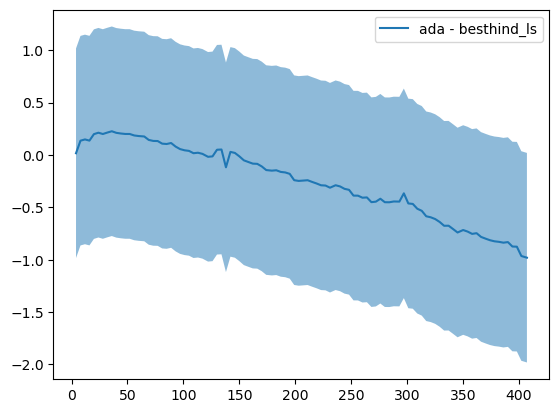

old 356


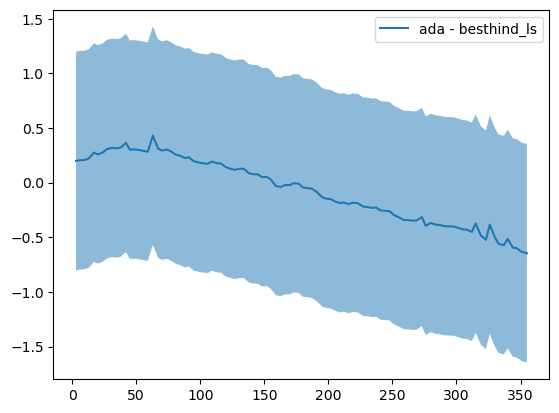

underweight 20


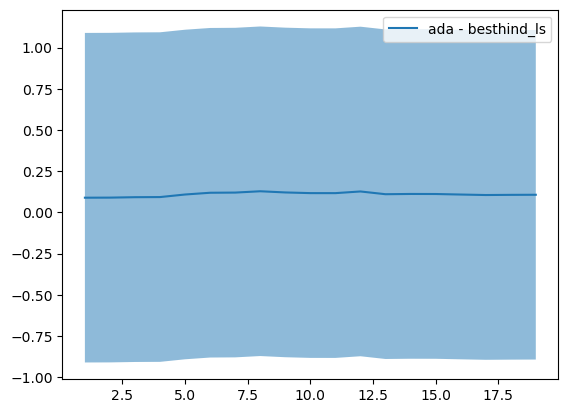

healthyweight 225


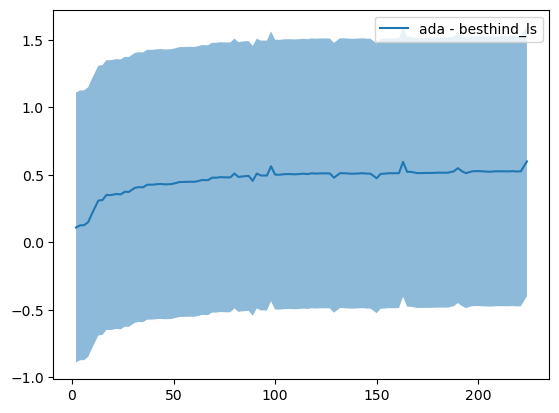

overweight 386


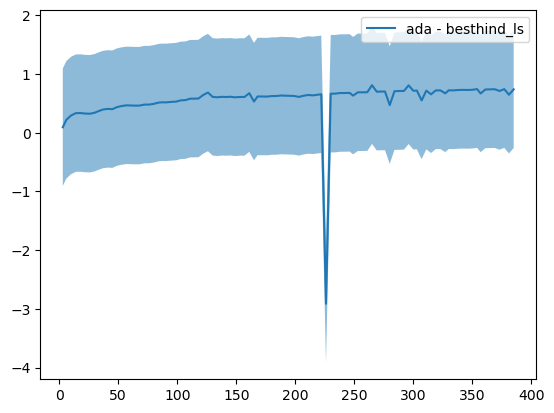

obese 707


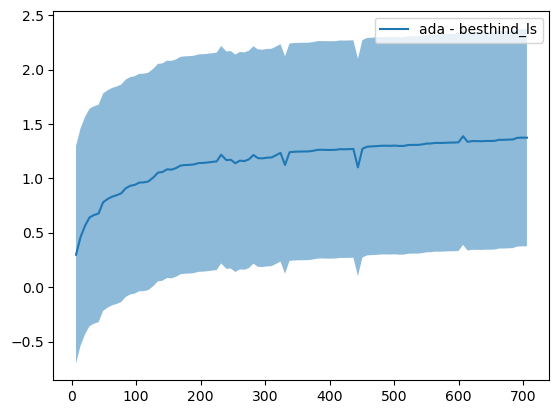

smoker 274


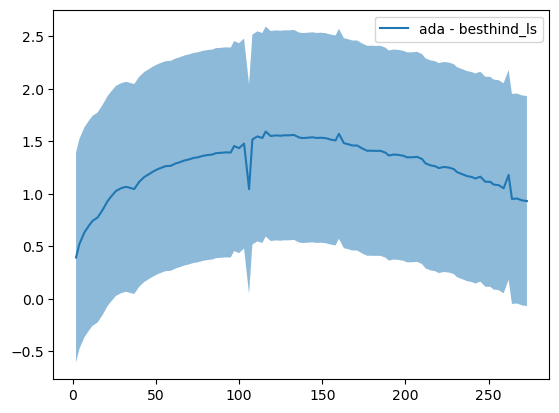

non-smoker 1064


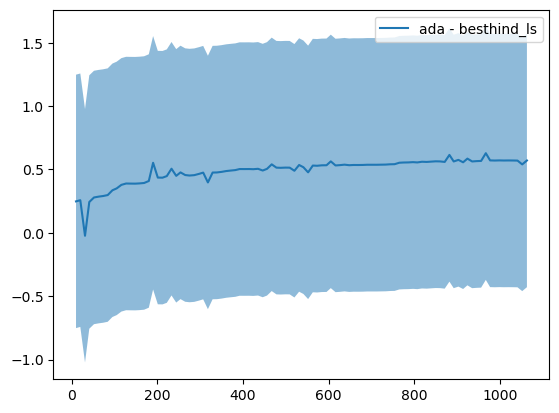

male 676


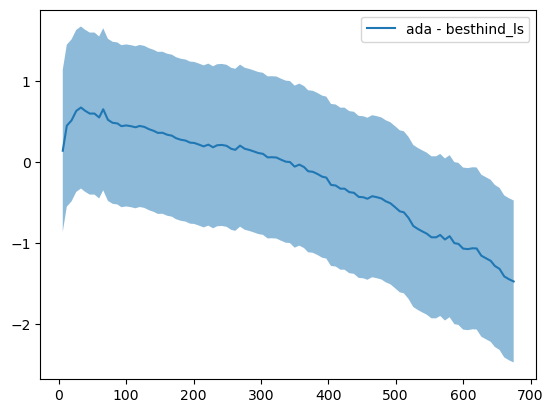

female 662


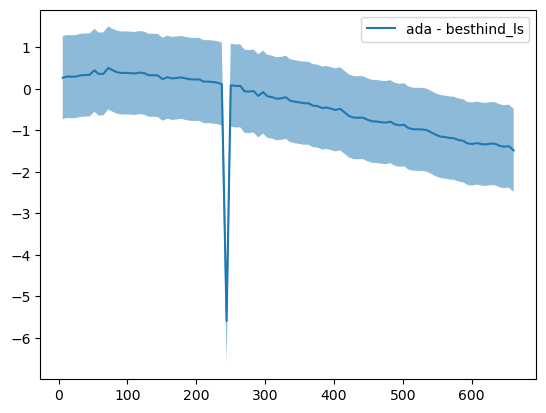

always_on 1338


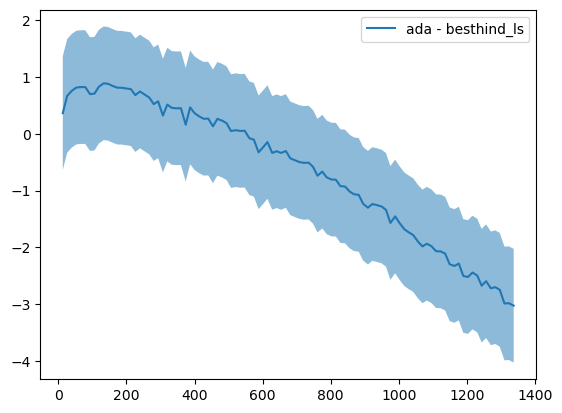

In [18]:
# with manual linear exp
Anh = b_Anh.Anh
for g_ind, gname in enumerate(A_t_medical_groups.columns):
    indices_g = (A_t_medical_groups[gname] == 1)
    X_dat_g = df_medical_mm_oh[indices_g].drop('charges', axis=1)
    y_dat_g = df_medical_mm_oh[indices_g]['charges']
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

## Now we take 10 random seeds and shuffle the dataframe, group indicators and report mean and std for group subsequence cum loss

stick to these random seeds

In [6]:
from bilevel.plotting_groupwise_perform import plot_groupwise

In [7]:
plot_ob = plot_groupwise(df_medical_mm_oh, 'charges', A_t_medical_groups)
plot_ob.build_all_seeds()
plot_ob.build_df_res()

100%|██████████| 1338/1338 [00:00<00:00, 6001.07it/s]


In [11]:
plot_ob.build_regret_curve()

TypeError: 'float' object cannot be interpreted as an integer

In [21]:
cl_Anh_list = [obj.Anh.cumloss_groupwise_ada for obj in plot_ob.Anh_obj_list] # 10 rows

In [30]:
plot_ob.Anh_obj_list

In [22]:
len(cl_Anh_list)

10

In [23]:
cl_Anh_groupwise_array = [0] * plot_ob.N # len is gnum, each has 10 shaped numpy array
for gnum in range(plot_ob.N):
    temp = []
    for ind in range(len(plot_ob.rand_seeds)):
        temp.append(cl_Anh_list[ind][gnum])
    cl_Anh_groupwise_array[gnum] = np.array(temp)

In [25]:
cl_Anh_groupwise_array[0].shape

(10, 574)

In [9]:
A_t_medical_groups.columns
subgroups_list = [['young', 'middle', 'old'], ['underweight', 'healthyweight', 'overweight',
       'obese'], ['smoker', 'non-smoker'], ['male', 'female'], ['always_on']]

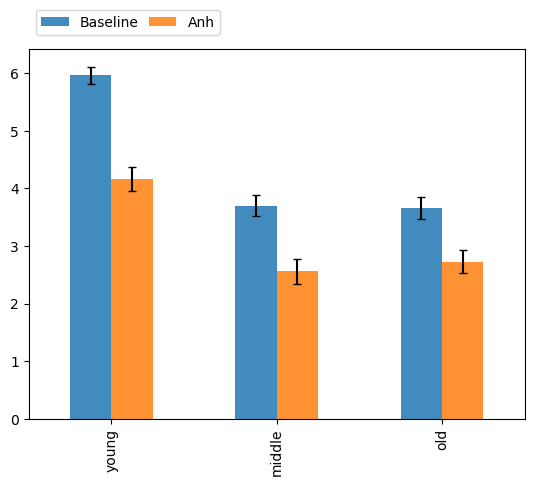

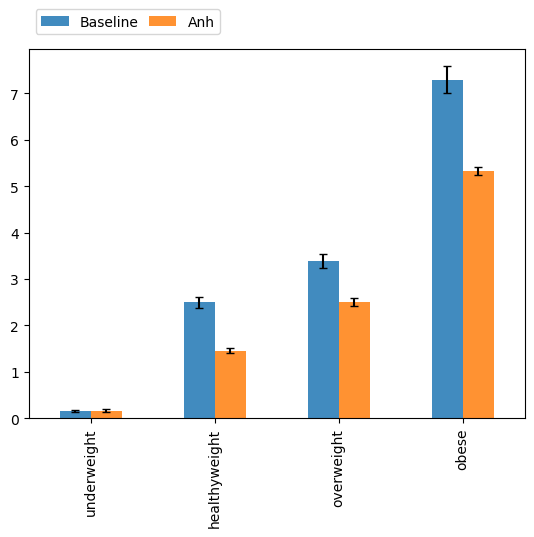

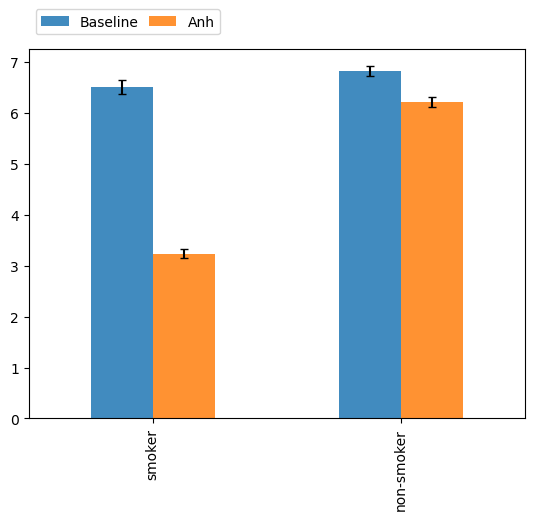

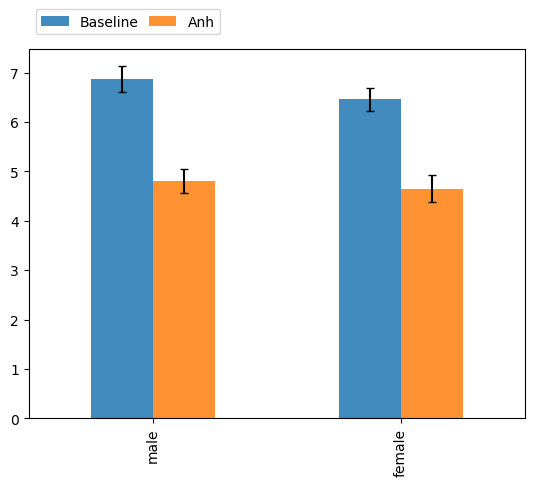

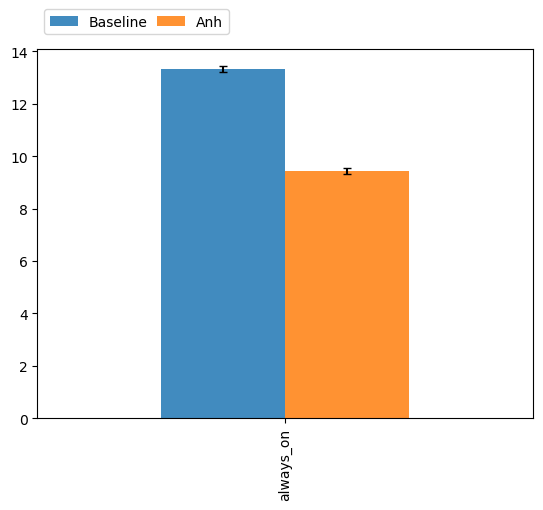

In [12]:
plot_ob.plot_save_subgroups(subgroups_list)

In [29]:
# np.random.randint(100, 1000, size = 10)
rand_seeds = [473, 503, 623, 550, 692, 989, 617, 458, 301, 205] # 10 random seeds used to shuffle the df_medical mm oh dataframe, A_t_medical_groups
# rand_seeds = [473, 503, 623]

In [30]:
med_group_names = ['age_young', 'age_middle', 'age_old', \
'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight','bmi_obese', 'smoker_yes', 'smoker_no',\
 'sex_male', 'sex_female', 'always_on']
print(med_group_names, len(med_group_names))

def add_to_dic_res(b_ridgebase, b_Anh):
    cumloss_base = b_ridgebase.expert.cumloss_groupwise
    cumloss_groupwise_ada = b_Anh.Anh.cumloss_groupwise_ada
    num_group = len(b_Anh.Anh.experts)
    for g_ind, gname in enumerate(med_group_names):
        base = cumloss_base[g_ind][-1]
        ada = cumloss_groupwise_ada[g_ind][-1]
        # dic_res[gname + '_base'].append(base)
        # dic_res[gname + '_Anh'].append(ada)
        dic_res_base[gname].append(base)
        dic_res_Anh[gname].append(ada)

['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese', 'smoker_yes', 'smoker_no', 'sex_male', 'sex_female', 'always_on'] 12


In [16]:
A_t_medical_groups.shape

(1338, 12)

In [32]:
from bilevel.manual_inv_LinearExpert import Manual_inv_LinearExpert

In [33]:
from collections import defaultdict
dic_res_base = defaultdict(list)
dic_res_Anh = defaultdict(list)
# l2_pen = 1.0
# l2_pen = 0.01
l2_pen = 0.1
for seed in rand_seeds:
    df_med_shuf = df_medical_mm_oh.sample(frac=1, random_state = seed)
    A_t_med_shuf = A_t_medical_groups.sample(frac=1, random_state = seed).to_numpy()
    X_dat = df_med_shuf.drop('charges', axis=1)
    y_dat = df_med_shuf['charges']

    dirname = './models_adult/baseline/'
    filename = 'manual_ridge_medical'+str(seed)

    X_dat_np = X_dat.to_numpy()
    y_dat_np = y_dat.to_numpy()

    # expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
    expridge = Manual_inv_LinearExpert(X_dat_np, y_dat_np, l2_pen = l2_pen)
    b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
    dirname = './models_adult/Anh/'
    # experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
    experts = [Manual_inv_LinearExpert(X_dat_np, y_dat_np, l2_pen = l2_pen) for _ in range(A_t_med_shuf.shape[1])]
    b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)
    add_to_dic_res(b_ridgebase, b_Anh)


100%|██████████| 1338/1338 [00:00<00:00, 6078.20it/s]


In [34]:
df_res_base, df_res_Anh = pd.DataFrame(dic_res_base), pd.DataFrame(dic_res_Anh)
# df_rbase_001, df_rAnh_001 = pd.DataFrame(dic_res_base), pd.DataFrame(dic_res_Anh)

In [22]:
df_rbase_1, df_rAnh_1 = pd.DataFrame(dic_res_base), pd.DataFrame(dic_res_Anh)

In [30]:
df_rbase_01, df_rAnh_01 = pd.DataFrame(dic_res_base), pd.DataFrame(dic_res_Anh)

In [32]:
np.sum(df_rAnh_1 - df_rbase_1 >= 0, axis = 0)

age_young            0
age_middle           0
age_old              0
bmi_underweight      9
bmi_healthyweight    0
bmi_overweight       0
bmi_obese            0
smoker_yes           0
smoker_no            0
sex_male             0
sex_female           0
always_on            0
dtype: int64

In [33]:
np.sum(df_rAnh_01 - df_rbase_01 >= 0, axis = 0)

age_young            0
age_middle           0
age_old              0
bmi_underweight      6
bmi_healthyweight    0
bmi_overweight       0
bmi_obese            0
smoker_yes           0
smoker_no            0
sex_male             0
sex_female           0
always_on            0
dtype: int64

In [34]:
np.sum(df_rAnh_001 - df_rbase_001 >= 0, axis = 0)

age_young            0
age_middle           0
age_old              0
bmi_underweight      7
bmi_healthyweight    0
bmi_overweight       0
bmi_obese            0
smoker_yes           0
smoker_no            0
sex_male             0
sex_female           0
always_on            0
dtype: int64

In [28]:
np.sum(df_rAnh_1 - df_rAnh_001 >= 0, axis = 0)

age_young            5
age_middle           4
age_old              8
bmi_underweight      5
bmi_healthyweight    7
bmi_overweight       4
bmi_obese            8
smoker_yes           9
smoker_no            0
sex_male             8
sex_female           6
always_on            6
dtype: int64

In [27]:
df_res_base

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
0,6.041836,3.795980,3.629666,0.185318,2.469502,3.473587,7.339076,6.403025,7.064458,6.837715,6.629767,13.467482
1,5.966987,3.630324,3.493304,0.147951,2.617627,3.436945,6.888092,6.121108,6.969506,6.589608,6.501006,13.090614
2,6.155751,3.661399,3.628201,0.143720,2.379496,3.353010,7.569125,6.333918,7.111433,6.744535,6.700816,13.445351
3,5.890921,3.578002,3.595112,0.144115,2.510816,3.350443,7.058662,5.938384,7.125651,6.517199,6.546836,13.064035
4,6.134137,3.546220,3.515313,0.130818,2.576060,3.401649,7.087143,6.234251,6.961420,6.946930,6.248741,13.195671
5,6.008087,4.002602,3.352163,0.159250,2.869601,3.845951,6.488050,6.661233,6.701619,6.514248,6.848604,13.362852
6,5.755949,3.980481,3.503043,0.153571,2.663943,3.471599,6.950360,6.219467,7.020006,6.621753,6.617720,13.239473
7,5.748313,3.682673,3.786899,0.122713,2.332915,3.315367,7.446890,6.314536,6.903348,7.132640,6.085244,13.217885
8,5.798072,3.669871,3.977678,0.168802,2.638778,3.575537,7.062504,6.334796,7.110824,7.056889,6.388731,13.445620
9,6.034490,3.550503,3.896581,0.149595,2.513749,3.606485,7.211746,6.518123,6.963450,7.195202,6.286372,13.481574


In [36]:
df_res_base.describe().loc[['mean', 'std']]

,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese,smoker_yes,smoker_no,sex_male,sex_female,always_on
mean,5.953454,3.709806,3.637796,0.150585,2.557249,3.483057,7.110165,6.307884,6.993172,6.815672,6.485384,13.301056
std,0.149169,0.165638,0.195029,0.017909,0.153935,0.158840,0.308055,0.201166,0.127673,0.256932,0.232326,0.159201


In [37]:
df_base_meansd = df_res_base.describe().loc[['mean', 'std']]
df_Anh_meansd = df_res_Anh.describe().loc[['mean', 'std']]

In [38]:
df_base_temp, df_Anh_temp = df_base_meansd.T, df_Anh_meansd.T

In [39]:
df_base_temp.rename(columns={'mean': 'mean_base', 'std': 'std_base'}, inplace=True)
df_Anh_temp.rename(columns={'mean': 'mean_Anh', 'std': 'std_Anh'}, inplace=True)


In [40]:
age_res_cols = ['age_young', 'age_middle', 'age_old']
bmi_res_cols = ['bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
smoker_res_cols = ['smoker_yes','smoker_no']
sex_res_cols = ['sex_male', 'sex_female']
always_res_cols = ['always_on']

In [41]:
df_base_temp_age = df_base_temp.loc[age_res_cols]
df_Anh_temp_age = df_Anh_temp.loc[age_res_cols]


df_base_temp_bmi = df_base_temp.loc[bmi_res_cols]
df_Anh_temp_bmi = df_Anh_temp.loc[bmi_res_cols]


In [42]:
df_age_res = pd.concat([df_base_temp_age, df_Anh_temp_age], axis =1)
df_bmi_res = pd.concat([df_base_temp_bmi, df_Anh_temp_bmi], axis =1)

In [43]:
df_age_res, df_bmi_res

(            mean_base  std_base  mean_Anh   std_Anh
 age_young    5.953454  0.149169  4.101831  0.199033
 age_middle   3.709806  0.165638  2.524585  0.211434
 age_old      3.637796  0.195029  2.622045  0.210242,
                    mean_base  std_base  mean_Anh   std_Anh
 bmi_underweight     0.150585  0.017909  0.163365  0.036645
 bmi_healthyweight   2.557249  0.153935  1.436703  0.074036
 bmi_overweight      3.483057  0.158840  2.519628  0.120127
 bmi_obese           7.110165  0.308055  5.128764  0.129481)

In [44]:
row_names = {'age_young':'young',
             'age_middle':'middle',
             'age_old':'old'}

df_age_res = df_age_res.rename(index = row_names)

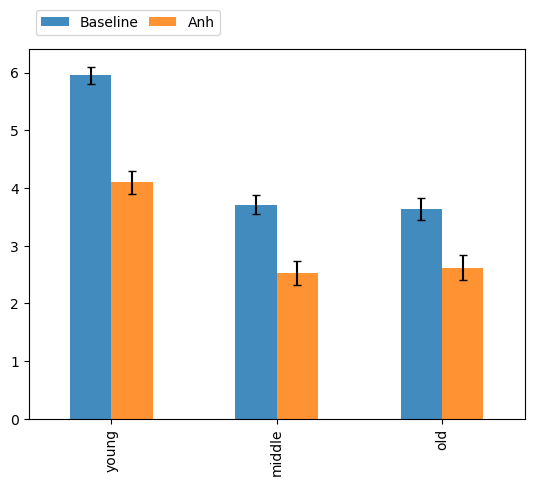

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

yerr = df_age_res[['std_base', 'std_Anh']].to_numpy().T
df_age_res[['mean_base', 'mean_Anh']].plot(kind='bar', yerr=yerr, alpha=0.85, error_kw=dict(ecolor='k'), capsize=3)
plt.legend(labels = ['Baseline', 'Anh'], bbox_to_anchor=(0, 1.02, 0.4,0.2), loc ='lower left', mode='expand', ncol = 2)

plt.show()

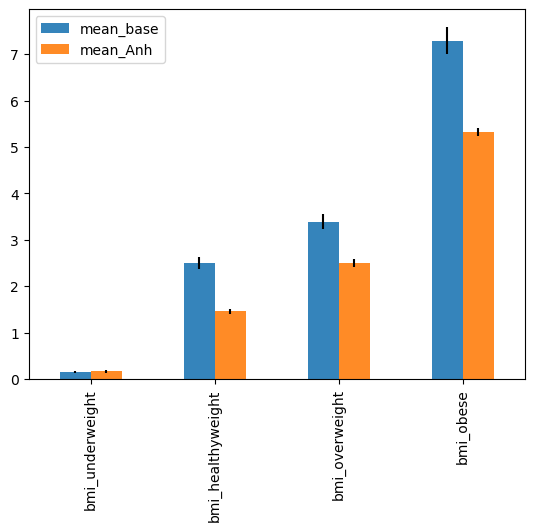

In [30]:
yerr = df_bmi_res[['std_base', 'std_Anh']].to_numpy().T

df_bmi_res[['mean_base', 'mean_Anh']].plot(kind='bar', yerr=yerr, alpha=0.9, error_kw=dict(ecolor='k'))
plt.show()

In [236]:
age_res_cols = ['age_young_base', 'age_young_Anh', 'age_middle_base', 'age_middle_Anh',
       'age_old_base', 'age_old_Anh']

bmi_res_cols = ['bmi_underweight_base','bmi_underweight_Anh', 'bmi_healthyweight_base', 'bmi_healthyweight_Anh', 
'bmi_overweight_base', 'bmi_overweight_Anh','bmi_obese_base', 'bmi_obese_Anh']

smoker_res_cols = ['smoker_yes_base', 'smoker_yes_Anh',
       'smoker_no_base', 'smoker_no_Anh']

sex_res_cols = ['sex_male_base', 'sex_male_Anh',
       'sex_female_base', 'sex_female_Anh']


always_res_cols = ['always_on_base', 'always_on_Anh']

In [235]:
df_res_stat.columns

Index(['age_young_base', 'age_young_Anh', 'age_middle_base', 'age_middle_Anh',
       'age_old_base', 'age_old_Anh', 'bmi_underweight_base',
       'bmi_underweight_Anh', 'bmi_healthyweight_base',
       'bmi_healthyweight_Anh', 'bmi_overweight_base', 'bmi_overweight_Anh',
       'bmi_obese_base', 'bmi_obese_Anh', 'smoker_yes_base', 'smoker_yes_Anh',
       'smoker_no_base', 'smoker_no_Anh', 'sex_male_base', 'sex_male_Anh',
       'sex_female_base', 'sex_female_Anh', 'always_on_base', 'always_on_Anh'],
      dtype='object')

In [241]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

for x, y in pairwise(bmi_res_cols):
    print(x,y)


bmi_underweight_base bmi_underweight_Anh
bmi_healthyweight_base bmi_healthyweight_Anh
bmi_overweight_base bmi_overweight_Anh
bmi_obese_base bmi_obese_Anh


In [248]:
df_res_stat.T.loc[['bmi_obese_base']]

,mean,std
bmi_obese_base,25.075512,0.249867


In [244]:
df_res_stat.T

,mean,std
age_young_base,12.884120,0.205372
age_young_Anh,8.278441,0.359380
age_middle_base,8.612265,0.244128
age_middle_Anh,5.039908,0.249079
age_old_base,9.817357,0.210403
age_old_Anh,7.250261,0.225652
bmi_underweight_base,0.207189,0.021865
bmi_underweight_Anh,0.258453,0.023365
bmi_healthyweight_base,2.148443,0.124860
bmi_healthyweight_Anh,2.640545,0.104750


In [224]:
v3, v4

(8.278440567340118, 0.3593800623258981)